In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

### Loading input data

In [3]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [6]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [7]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [9]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Making information footprints

In [10]:
def simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                  rnap_emat, rep_emat, P, R, M, N,
                  ep_wt=0, er_wt=0, ep_NS=0, er_NS=0):

    l_tr = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        rep_mut = mut[rep_start:rep_end].upper()
        rv['pbound'] = tregs.simulate.simrep_pbound_cp(
                            rnap_mut, rep_mut, rnap_emat, rep_emat, P, R, M, N,
                            ep_wt=ep_wt, er_wt=er_wt, ep_NS=ep_NS, er_NS=er_NS)
        
        l_tr.append(rv)
    df_simrep = pd.DataFrame.from_records(l_tr)

    return df_simrep


def get_dna_cnt(n_seqs):

    dna_cnt = np.random.exponential(1, size=n_seqs) * 10

    dna_cnt_up = []
    for cnt in dna_cnt:
        dna_cnt_up.append(math.ceil(cnt))

    return dna_cnt


def simrep_cp(wtseq, rnap_wtseq, rep_wtseq, rnap_emat, rep_emat, 
           ep_wt, er_wt, P, R, M, N,
           num_mutants=10000, mutrate=0.1, scaling_factor=100,
           ep_NS=0, er_NS=0):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=mutrate,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq,rep_wtseq)

    df_simrep = simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                            rnap_emat, rep_emat, P, R, M, N,
                            ep_wt=ep_wt, er_wt=er_wt, ep_NS=ep_NS, er_NS=er_NS)
    
    dna_cnt = get_dna_cnt(len(df_simrep))
    df_simrep['ct_0'] = dna_cnt
    df_simrep = df_simrep[df_simrep.ct_0 != 0.0]

    df_simrep['ct_1'] = 0.1 + df_simrep['ct_0'] * df_simrep['pbound'] * scaling_factor
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(int)

    df_simrep['ct_0'] = df_simrep['ct_0'].astype(float)
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(float)
    df_simrep['norm_ct_1'] = df_simrep['ct_1'] / df_simrep['ct_0']

    return df_simrep

## Simulate dataset and information footprint

In [44]:
def plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound,
                   outfile=None):
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)
    
    fig, ax = plt.subplots(figsize=(8,2.5))
    ax.set_xlim(-50, 30)

    ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
    ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
    ax.axvspan(2, 2 + 17, alpha=0.7, color='#E8B19D')

    ax.set_ylim(top=max(footprint)*1.15)
    ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                            8,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')
    
    ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                        17,
                                        max(footprint) * 0.2,
                                        facecolor='#D56C55',
                                        clip_on=False,
                                        linewidth = 0))
    ax.text(2 + 0.5 * 17, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
                ha='center', va='baseline')


    windowsize=3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information (bits)', fontsize=12)

    custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]
    plt.legend(custom_lines,
            ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
            bbox_to_anchor=(1.35, 0.95), frameon=False)

    plt.tight_layout()
    if outfile is not None:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

In [45]:
ep_wt, er_wt = -5, -15
P = 4600
R = 15
M = 1
N = len(genome)

df = simrep_cp(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
               ep_wt, er_wt, P, R, M, N)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

nbins = 2
upper_bound = np.mean(mu_data)

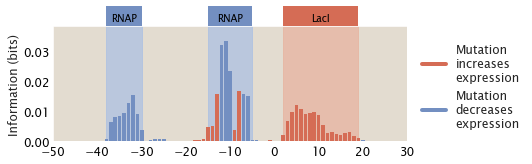

In [46]:
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound,
               outfile='../../figs/chemical_potential_M1.png')

In [47]:
ep_wt, er_wt = -5, -15
P = 4600
R = 15
M = 50
N = len(genome)

df = simrep_cp(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
               ep_wt, er_wt, P, R, M, N)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

nbins = 2
upper_bound = np.mean(mu_data)

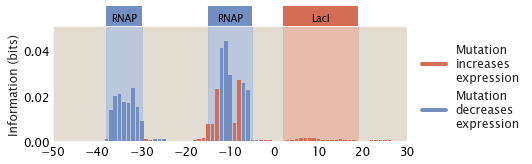

In [48]:
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound,
               outfile='../../figs/chemical_potential_M50.png')

In [17]:
ep_wt, er_wt = -5, -15
P = 4600
R = 15
M = 100
N = len(genome)

df = simrep_cp(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
               ep_wt, er_wt, P, R, M, N)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

nbins = 2
upper_bound = np.mean(mu_data)

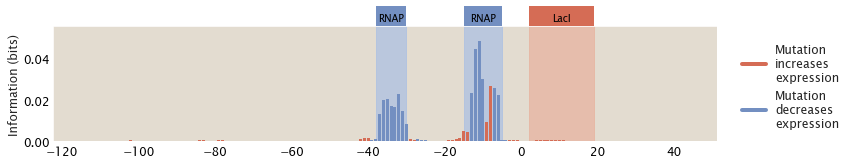

In [18]:
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound)